In [3]:
import os, math
import pandas as pd
import pandapower as pp
import numpy as np

from pandapower.file_io import from_json, to_json

data_dir = 'Modified_116_LV_CSV'

load C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ortools\.libs\zlib1.dll...
load C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ortools\.libs\abseil_dll.dll...
load C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ortools\.libs\utf8_validity.dll...
load C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ortools\.libs\re2.dll...
load C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ortools\.libs\libprotobuf.dll...
load C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python31

In [41]:
# Source data
source_df = pd.read_csv(os.path.join(data_dir,'Source.csv'), skiprows=1, sep='=')
source_dict = {i:float(row.iloc[0].split()[0]) for i, row in source_df.iterrows()}
print(source_dict)

source_dict['ISC1'] = source_dict['ISC1'] / 1000
source_dict['ISC3'] = source_dict['ISC3'] / 1000

# Transformer data
trafo_df = pd.read_csv(os.path.join(data_dir,'Transformer.csv'), skiprows=1, sep=';')
trafo_dict = trafo_df.iloc[0].to_dict()
print(trafo_dict)

{'Voltage': 11.0, 'pu': 1.05, 'ISC3': 3000.0, 'ISC1': 5.0}
{'Name': 'TR1', ' phases': 3, ' bus1': 'SourceBus', ' bus2': 1, ' kV_pri': 11, ' kV_sec': 0.416, ' MVA': 0.8, ' Conn_pri': ' Delta', ' Conn_sec': ' Wye', ' %XHL': 4, '% resistance': 0.4}


In [42]:
s_sc_mva = np.sqrt(3) * source_dict['Voltage'] * source_dict['ISC3'] #MVA

net = pp.create_empty_network()

bus_map = {}

hv_bus = pp.create_bus(net, name=trafo_dict[' bus1'], vn_kv=source_dict['Voltage'], type="b")
lv_bus = pp.create_bus(net, name=trafo_dict[' bus2'], vn_kv=trafo_dict[' kV_sec'], type="b")

bus_map[trafo_dict[' bus1']] = hv_bus
bus_map[trafo_dict[' bus2']] = lv_bus

pp.create_ext_grid(
    net, bus=hv_bus, vm_pu=source_dict['pu'],
    s_sc_max_mva=s_sc_mva,
    rx_max=0.1, rx_min=None,
    # max_p_mw=None, min_p_mw=None,
    # max_q_mvar=None, min_q_mvar=None, index=None,
    r0x0_max=0.1, x0x_max=1.0
)

pp.create_transformer_from_parameters(
    net=net, hv_bus=hv_bus, lv_bus=lv_bus,
    sn_mva=trafo_dict[' MVA'],
    vn_hv_kv=trafo_dict[' kV_pri'],
    vn_lv_kv=trafo_dict[' kV_sec'],
    vk_percent=trafo_dict[' %XHL'],
    vkr_percent=trafo_dict['% resistance'],
    pfe_kw=0.0, i0_percent=0.0, shift_degree=30, 
    name=trafo_dict['Name']
)

pp.create_shunt(
    net, bus=lv_bus,
    q_mvar=-0.01, p_mw=10e-3,
    vn_kv=trafo_dict[' kV_sec'],
    name="trafo_lv_shunt"
)

0

In [43]:
lines_df = pd.read_excel(os.path.join(data_dir, "Lines.xlsx"), skiprows=1)
lines_df['Length'] = lines_df['Length'] / 1000 # m to km
lines_df['Units'] = 'km'
lines_df.head()

lineCodes_df = pd.read_csv(os.path.join(data_dir, "LineCodes.csv"), skiprows=1, sep=';')

all_bus_ids = np.unique(lines_df[['Bus1', 'Bus2']].values.ravel('K'))
for id in all_bus_ids:
    id = math.floor(id)
    if id not in bus_map.keys():
        bus = pp.create_bus(net, name=id, vn_kv=trafo_dict[' kV_sec'], type="b")
        bus_map[id] = bus

In [44]:
lineCodes_df['max_i_ka'] = np.ones(len(lineCodes_df))

In [45]:
full_line_df = lines_df.merge(lineCodes_df, left_on="LineCode", right_on="Name", how="left")
# full_line_df.head(10)

net.line.drop(net.line.index, inplace=True)
for _, line in full_line_df.iterrows():
    # print(line)

    if (line['C0'] == 0): line['C0'] = 200 # nF/km
    if (line['C1'] == 0): line['C1'] = 200 # nF/km
    
    pp.create_line_from_parameters(
        net, from_bus = bus_map[math.floor(line['Bus1'])],
        to_bus = bus_map[math.floor(line['Bus2'])],
        length_km = line['Length'],
        r_ohm_per_km=line["R1"], r0_ohm_per_km=line["R1"] * 2,
        x_ohm_per_km=line["X1"], x0_ohm_per_km=line["X0"],
        c_nf_per_km=line["C1"], c0_nf_per_km=line["C0"],
        max_i_ka=line["max_i_ka"],
        name=line["Name_x"], type='cs',
    )

In [46]:
suspicious_lines = net.line[
    (np.isclose(net.line["length_km"], 0, rtol=1e-2)) |
    (np.isclose(net.line["r_ohm_per_km"], 0, rtol=1e-2)) |
    (np.isclose(net.line["x_ohm_per_km"], 0, rtol=1e-2))
]
suspicious_lines

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service,r0_ohm_per_km,x0_ohm_per_km,c0_nf_per_km,g0_us_per_km


In [47]:
net.trafo["vector_group"] = 'Dyn'
net.trafo["vk0_percent"] = net.trafo["vk_percent"]
net.trafo["vkr0_percent"] = net.trafo["vkr_percent"]
net.trafo["mag0_percent"] = 100
net.trafo["mag0_rx"] = 0
net.trafo["si0_hv_partial"] = 0.9

In [48]:
to_json(net, os.path.join(data_dir, "no_load_network.json"))

In [49]:
import pandas as pd

def export_results(file_path, net, init='auto', max_iteration=100, tolerance_mva=1e-8):
    """
    Export all result DataFrames (attributes of net starting with 'res_') to an Excel file.
    
    Parameters:
    - file_path: str, path to the Excel file to save the results.
    - net: object containing result DataFrames as attributes starting with 'res_'.
    """

    try:
        pp.runpp_3ph(
            net, init=init,
            max_iteration=max_iteration,
            tolerance_mva=tolerance_mva,
            calc_voltage_angles=True,
            v_debug=True
        )
    except Exception as e:
        return e  # or raise e if you want the exception to propagate

    with pd.ExcelWriter(file_path) as writer:
        for attr in dir(net):
            if attr.startswith("res_"):
                df = getattr(net, attr)
                if isinstance(df, pd.DataFrame) and not df.empty:
                    sheet_name = attr[:31]  # Excel sheet names must be <= 31 characters
                    df.to_excel(writer, sheet_name=sheet_name)
    return True

def debug_result(net, init='auto', max_iteration=100, tolerance_mva=1e-8):
    try:
        pp.runpp_3ph(
            net, init=init,
            max_iteration=max_iteration,
            tolerance_mva=tolerance_mva,
            calc_voltage_angles=True,
            v_debug=True
        )
    except Exception as e:
        return False
    return True

In [50]:
pp.diagnostic(net)



_____________ PANDAPOWER DIAGNOSTIC TOOL _____________ 


 --------


 --------


 --------

Checking for impedance values close to zero...

line 1: r_ohm <= 0.001 or x_ohm <= 0.001
line 2: r_ohm <= 0.001 or x_ohm <= 0.001
line 3: r_ohm <= 0.001 or x_ohm <= 0.001
line 4: r_ohm <= 0.001 or x_ohm <= 0.001
line 5: r_ohm <= 0.001 or x_ohm <= 0.001
line 7: r_ohm <= 0.001 or x_ohm <= 0.001
line 8: r_ohm <= 0.001 or x_ohm <= 0.001
line 9: r_ohm <= 0.001 or x_ohm <= 0.001
line 10: r_ohm <= 0.001 or x_ohm <= 0.001
line 11: r_ohm <= 0.001 or x_ohm <= 0.001
line 12: r_ohm <= 0.001 or x_ohm <= 0.001
line 13: r_ohm <= 0.001 or x_ohm <= 0.001
line 14: r_ohm <= 0.001 or x_ohm <= 0.001
line 15: r_ohm <= 0.001 or x_ohm <= 0.001
line 19: r_ohm <= 0.001 or x_ohm <= 0.001
line 21: r_ohm <= 0.001 or x_ohm <= 0.001
line 22: r_ohm <= 0.001 or x_ohm <= 0.001
line 23: r_ohm <= 0.001 or x_ohm <= 0.001
line 24: r_ohm <= 0.001 or x_ohm <= 0.001
line 25: r_ohm <= 0.001 or x_ohm <= 0.001
line 26: r_ohm <= 0.001 o

{'impedance_values_close_to_zero': [{'line': [1,
    2,
    3,
    4,
    5,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    19,
    21,
    22,
    23,
    24,
    25,
    26,
    29,
    30,
    31,
    33,
    35,
    36,
    37,
    39,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    51,
    54,
    55,
    56,
    57,
    58,
    61,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    71,
    72,
    74,
    76,
    79,
    80,
    82,
    84,
    85,
    86,
    87,
    88,
    89,
    90,
    91,
    93,
    94,
    97,
    98,
    99,
    101,
    102,
    103,
    105,
    106,
    107,
    108,
    109,
    110,
    111,
    112,
    113,
    114]}]}

In [51]:
export_results("basic_network_results.xlsx", net)

True

In [ ]:
# Create Loads
loads_df = pd.read_excel(os.path.join(data_dir, "Loads.xlsx"), skiprows=2)
# print(loads_df.head(10))
sample_loads = loads_df.sample(25)

net.asymmetric_load.drop(net.asymmetric_load.index, inplace=True)
load_map = {}
for _, row in sample_loads.iterrows():
    # print(_, '->', row)
    bus_id = math.floor(row['Bus'])
    pa = qa = pb = qb = pc = qc = 0
    if (bus_id in bus_map) & (row['phases'] in {'A', 'B', 'C'}):
        if row['phases']=='A':
            pa = row['kW']
            qa = row['kW'] * np.tan(np.arccos(row['PF']))
        elif row['phases']=='B':
            pb = row['kW']
            qb = row['kW'] * np.tan(np.arccos(row['PF']))
        else: # row['phases']=='C'
            pc = row['kW']
            qc = row['kW'] * np.tan(np.arccos(row['PF']))
        load = pp.create_asymmetric_load(
            net, bus=net.bus.index[net.bus.name==bus_id][0],
            p_a_mw=pa / 1000, q_a_mvar=qa / 1000,
            p_b_mw=pb / 1000, q_b_mvar=qb / 1000,
            p_c_mw=pc / 1000, q_c_mvar=qc / 1000,
            name=row['Name']
        )
        load_map[load] = row['Yearly']

# print(net.asymmetric_load)
export_results("batch_network_results.xlsx", net)

pandapower.powerflow.LoadflowNotConverged('Power Flow nr did not converge after 100 iterations!')

In [ ]:
N = 1
batch = list(range(5, 51, 5))
for b in batch:
    success = 0
    for i in range(N):
        sample_loads = loads_df.sample(b)

        net.asymmetric_load.drop(net.asymmetric_load.index, inplace=True)
        load_map = {}
        for _, row in sample_loads.iterrows():
            # print(_, '->', row)
            bus_id = math.floor(row['Bus'])
            pa = qa = pb = qb = pc = qc = 0
            if (bus_id in bus_map) & (row['phases'] in {'A', 'B', 'C'}):
                if row['phases']=='A':
                    pa = row['kW']
                    qa = row['kW'] * np.tan(np.arccos(row['PF']))
                elif row['phases']=='B':
                    pb = row['kW']
                    qb = row['kW'] * np.tan(np.arccos(row['PF']))
                else: # row['phases']=='C'
                    pc = row['kW']
                    qc = row['kW'] * np.tan(np.arccos(row['PF']))
                load = pp.create_asymmetric_load(
                    net, bus=net.bus.index[net.bus.name==bus_id][0],
                    p_a_mw=pa, q_a_mvar=qa,
                    p_b_mw=pb, q_b_mvar=qb,
                    p_c_mw=pc, q_c_mvar=qc,
                    name=row['Name']
                )
                load_map[load] = row['Yearly']

        if debug_result(net, init='flat'): success += 1
    print(f"[{b}]\tConvergence rate = {100 * success / N} %")

C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pypower\newtonpf.py:337: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\create_jacobian.py:28: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\runpp_3ph.py:478: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

[5]	Convergence rate = 100.0 %


C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\create_jacobian.py:28: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pypower\newtonpf.py:337: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\runpp_3ph.py:478: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

[10]	Convergence rate = 100.0 %


C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pypower\newtonpf.py:337: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\create_jacobian.py:28: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\runpp_3ph.py:478: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

[15]	Convergence rate = 100.0 %


C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pypower\newtonpf.py:337: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\create_jacobian.py:28: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\runpp_3ph.py:478: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

[20]	Convergence rate = 100.0 %


C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\create_jacobian.py:28: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pypower\newtonpf.py:337: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\runpp_3ph.py:478: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

[25]	Convergence rate = 100.0 %


C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pypower\newtonpf.py:337: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\create_jacobian.py:28: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\runpp_3ph.py:478: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

[30]	Convergence rate = 100.0 %


C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pypower\newtonpf.py:337: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\create_jacobian.py:28: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\runpp_3ph.py:478: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

[35]	Convergence rate = 100.0 %


C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pypower\newtonpf.py:337: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\create_jacobian.py:28: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\runpp_3ph.py:478: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

[40]	Convergence rate = 100.0 %


C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pypower\newtonpf.py:337: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\create_jacobian.py:28: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\runpp_3ph.py:478: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

[45]	Convergence rate = 100.0 %


C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\create_jacobian.py:28: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pypower\newtonpf.py:337: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\runpp_3ph.py:478: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

[50]	Convergence rate = 40.0 %


In [ ]:
# Load by load:
load_problem = []

for _, row in loads_df.iterrows():
    net.asymmetric_load.drop(net.asymmetric_load.index, inplace=True)
    
    # print(_, '->', row)
    bus_id = math.floor(row['Bus'])
    pa = qa = pb = qb = pc = qc = 0
    if (bus_id in bus_map) & (row['phases'] in {'A', 'B', 'C'}):
        if row['phases']=='A':
            pa = row['kW']
            qa = row['kW'] * np.tan(np.arccos(row['PF']))
        elif row['phases']=='B':
            pb = row['kW']
            qb = row['kW'] * np.tan(np.arccos(row['PF']))
        else: # row['phases']=='C'
            pc = row['kW']
            qc = row['kW'] * np.tan(np.arccos(row['PF']))
        load = pp.create_asymmetric_load(
            net, bus=net.bus.index[net.bus.name==bus_id][0],
            p_a_mw=pa / 1000, q_a_mvar=qa / 1000,
            p_b_mw=pb / 1000, q_b_mvar=qb / 1000,
            p_c_mw=pc / 1000, q_c_mvar=qc / 1000,
            name=row['Name'] 
        )
    if not debug_result(net, init='flat'): load_problem.append(row['Name'])

load_problem

[]

In [ ]:
# Create Loads
loads_df = pd.read_excel(os.path.join(data_dir, "Loads.xlsx"), skiprows=2)
# print(loads_df.head(10))

net.asymmetric_load.drop(net.asymmetric_load.index, inplace=True)
load_map = {}
for _, row in loads_df.iterrows():
    # print(_, '->', row)
    bus_id = math.floor(row['Bus'])
    pa = qa = pb = qb = pc = qc = 0
    if (bus_id in bus_map) & (row['phases'] in {'A', 'B', 'C'}):
        if row['phases']=='A':
            pa = row['kW']
            qa = row['kW'] * np.tan(np.arccos(row['PF']))
        elif row['phases']=='B':
            pb = row['kW']
            qb = row['kW'] * np.tan(np.arccos(row['PF']))
        else: # row['phases']=='C'
            pc = row['kW']
            qc = row['kW'] * np.tan(np.arccos(row['PF']))
        load = pp.create_asymmetric_load(
            net, bus=net.bus.index[net.bus.name==bus_id][0],
            p_a_mw=pa / 1000, q_a_mvar=qa / 1000,
            p_b_mw=pb / 1000, q_b_mvar=qb / 1000,
            p_c_mw=pc / 1000, q_c_mvar=qc / 1000,
            name=row['Name']
        )
        load_map[load] = row['Yearly']

export_results("full_network_results.xlsx", net, max_iteration=1000, tolerance_mva=1e-6)

pandapower.powerflow.LoadflowNotConverged('Power Flow nr did not converge after 1000 iterations!')

Get maximum number of loads that converges

In [ ]:
N = 1000
batch = range(45, len(loads_df)+1)

# batch_loads = {}
# batch_bus = {}
max_batch = 0
for b in batch:
    for i in range(N):
        sample_loads = loads_df.sample(b)

        net.asymmetric_load.drop(net.asymmetric_load.index, inplace=True)
        for _, row in sample_loads.iterrows():
            # print(_, '->', row)
            bus_id = math.floor(row['Bus'])
            pa = qa = pb = qb = pc = qc = 0
            if (bus_id in bus_map) & (row['phases'] in {'A', 'B', 'C'}):
                if row['phases']=='A':
                    pa = row['kW']
                    qa = row['kW'] * np.tan(np.arccos(row['PF']))
                elif row['phases']=='B':
                    pb = row['kW']
                    qb = row['kW'] * np.tan(np.arccos(row['PF']))
                else: # row['phases']=='C'
                    pc = row['kW']
                    qc = row['kW'] * np.tan(np.arccos(row['PF']))
                load = pp.create_asymmetric_load(
                    net, bus=bus_map[bus_id],
                    p_a_mw=pa, q_a_mvar=qa,
                    p_b_mw=pb, q_b_mvar=qb,
                    p_c_mw=pc, q_c_mvar=qc,
                    name=row['Name']
                )

        if debug_result(net, init='flat'):
            # batch_loads[b] = list(net.asymmetric_load['name'])
            # batch_bus[b] = list(net.asymmetric_load['bus'])
            max_batch = b
            break

from pandapower.file_io import to_json

to_json(net, os.path.join(data_dir, "{max_batch}_loads_network.json"))

C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\create_jacobian.py:28: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pypower\newtonpf.py:337: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\runpp_3ph.py:478: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

In [59]:
import pandapower.networks as pn
import pandapower as pp
offpeak_net = pn.ieee_european_lv_asymmetric('on_peak_566')

pp.runpp_3ph(
    offpeak_net, init='auto',
    max_iteration=100,
    tolerance_mva=1e-8,
    calc_voltage_angles=True,
    v_debug=True
)

In [60]:
def hc_violation(net):
    # pp.runpp(net)
    return any([
        net.res_trafo_3ph.loading_percent.max() > 100, # 110
        net.res_line_3ph.loading_a_percent.max() > 100, # 110
        net.res_line_3ph.loading_b_percent.max() > 100,
        net.res_line_3ph.loading_c_percent.max() > 100,
        net.res_bus_3ph.vm_a_pu.max() >= 1.05, # 1.10
        net.res_bus_3ph.vm_b_pu.max() >= 1.05,
        net.res_bus_3ph.vm_c_pu.max() >= 1.05,
        net.res_bus_3ph.vm_a_pu.min() <= 0.95, # 0.85
        net.res_bus_3ph.vm_b_pu.min() <= 0.95,
        net.res_bus_3ph.vm_c_pu.min() <= 0.95
    ])

In [ ]:
farthest_load_net = from_json(os.path.join(data_dir, "farthest_load_network.json"))
print(farthest_load_net.asymmetric_load.p_a_mw)

inc = 5e-5
success = True
vm_pu = pd.DataFrame(columns=['p_a_mw', 'vm_a_pu', 'vm_b_pu', 'vm_c_pu'])
while success:
    # print(farthest_load_net.asymmetric_load.p_a_mw)
    if debug_result(farthest_load_net, init='flat'):
        new_row = pd.concat([
            farthest_load_net.asymmetric_load.p_a_mw,
            farthest_load_net.res_bus_3ph.loc[farthest_load_net.asymmetric_load.bus, ['vm_a_pu', 'vm_b_pu', 'vm_c_pu']].reset_index(drop=True)
        ], axis=1)
        vm_pu = pd.concat([vm_pu, new_row], ignore_index=True)

        farthest_load_net.asymmetric_load.p_a_mw += inc
    else:
        success = False

0    0.001
Name: p_a_mw, dtype: float64
0    0.001
Name: p_a_mw, dtype: float64


C:\Users\vitor\AppData\Local\Temp\ipykernel_9248\2883377371.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  vm_pu = pd.concat([vm_pu, new_row], ignore_index=True)


0    0.00105
Name: p_a_mw, dtype: float64
0    0.0011
Name: p_a_mw, dtype: float64
0    0.00115
Name: p_a_mw, dtype: float64
0    0.0012
Name: p_a_mw, dtype: float64
0    0.00125
Name: p_a_mw, dtype: float64
0    0.0013
Name: p_a_mw, dtype: float64
0    0.00135
Name: p_a_mw, dtype: float64
0    0.0014
Name: p_a_mw, dtype: float64
0    0.00145
Name: p_a_mw, dtype: float64
0    0.0015
Name: p_a_mw, dtype: float64
0    0.00155
Name: p_a_mw, dtype: float64
0    0.0016
Name: p_a_mw, dtype: float64
0    0.00165
Name: p_a_mw, dtype: float64
0    0.0017
Name: p_a_mw, dtype: float64
0    0.00175
Name: p_a_mw, dtype: float64
0    0.0018
Name: p_a_mw, dtype: float64
0    0.00185
Name: p_a_mw, dtype: float64
0    0.0019
Name: p_a_mw, dtype: float64
0    0.00195
Name: p_a_mw, dtype: float64
0    0.002
Name: p_a_mw, dtype: float64
0    0.00205
Name: p_a_mw, dtype: float64
0    0.0021
Name: p_a_mw, dtype: float64
0    0.00215
Name: p_a_mw, dtype: float64
0    0.0022
Name: p_a_mw, dtype: float64
0    

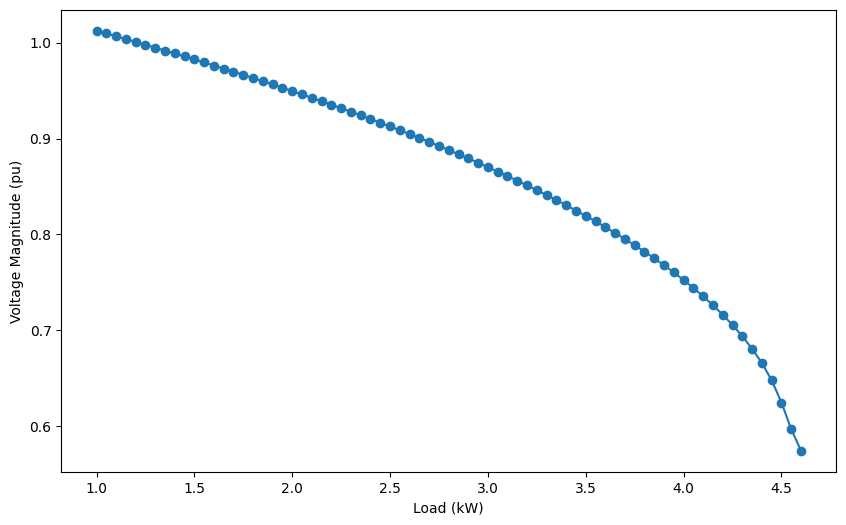

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.plot(vm_pu['p_a_mw']*1000, vm_pu['vm_a_pu'], label='Phase A', marker='o')
# plt.title('Load (kW) X Voltage Magnitude (pu)')
plt.xlabel('Load (kW)')
plt.ylabel('Voltage Magnitude (pu)')

plt.savefig(os.path.join('images', 'farthest_load_X_voltage.png'))

In [19]:
net54 = from_json(os.path.join(data_dir, '54_loads_network.json'))

pd.DataFrame(net54.asymmetric_load).sort_values(by='bus')
# net54.asymmetric_load

,name,bus,p_a_mw,q_a_mvar,p_b_mw,q_b_mvar,p_c_mw,q_c_mvar,sn_mva,scaling,in_service,type
14,LOAD1,5,1.0,0.328684,0.0,0.000000,0.0,0.000000,NaN,1.0,True,wye
44,LOAD2,7,0.0,0.000000,1.0,0.328684,0.0,0.000000,NaN,1.0,True,wye
12,LOAD3,10,1.0,0.328684,0.0,0.000000,0.0,0.000000,NaN,1.0,True,wye
10,LOAD4,11,1.0,0.328684,0.0,0.000000,0.0,0.000000,NaN,1.0,True,wye
48,LOAD5,12,1.0,0.328684,0.0,0.000000,0.0,0.000000,NaN,1.0,True,wye
7,LOAD6,13,0.0,0.000000,1.0,0.328684,0.0,0.000000,NaN,1.0,True,wye
28,LOAD7,21,0.0,0.000000,1.0,0.328684,0.0,0.000000,NaN,1.0,True,wye
1,LOAD8,25,0.0,0.000000,0.0,0.000000,1.0,0.328684,NaN,1.0,True,wye
15,LOAD9,26,1.0,0.328684,0.0,0.000000,0.0,0.000000,NaN,1.0,True,wye
47,LOAD10,29,0.0,0.000000,1.0,0.328684,0.0,0.000000,NaN,1.0,True,wye
